In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
import shutil
import torch.nn as nn
from skimage import io
import torchvision
import cv2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from albumentations.pytorch import ToTensorV2
from torchvision import utils

from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BASE_DIR = "../input/tensorflow-great-barrier-reef/train_images/"
WORKING_DIR = "../input/data-conversion-to-4k/train_img"
NUM_EPOCHS = 5

In [3]:
train_df = pd.read_csv("../input/tensorflow-great-barrier-reef/train.csv")
# train_df['annotations'].iloc[3]
train_df['annotations'] = train_df['annotations'].apply(eval)
func = lambda x: "video_"+x.split("-")[0]+"/"+x.split("-")[1]+".jpg"
# vid_func = lambda x: "video_"+x.split("-")[0]

train_df["img_path"] = train_df["image_id"].apply(func)


In [4]:
train_df["no_of_bbox"] = train_df["annotations"].apply(lambda x: len(x))
# train_df.head(20)

In [5]:
train_df = train_df[train_df["no_of_bbox"]>0].reset_index(drop=True)
# train_df

### Data loader class:

In [6]:
class ReefDataset:

    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
#         self.working_dir = "./train_img/video_0"
        
        
    def can_augment(self, boxes):
        box_outside_image = ((boxes[:, 0] < 0).any() or (boxes[:, 1] < 0).any() 
                             or (boxes[:, 2] > 1280).any() or (boxes[:, 3] > 720).any())
        return not box_outside_image

    def __getitem__(self, i):

        row = self.df.iloc[i]
#         print(WORKING_DIR)
#         print(row["img_path"])
        image = cv2.imread(f'{WORKING_DIR}/{row["img_path"]}').astype(np.float32)
#         print(image.shape)
#         print(f'{BASE_DIR}/{row["img_path"]}')
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /=255.0
        
        
        boxes = pd.DataFrame(row['annotations'], columns=['x', 'y', 'width', 'height']).astype(np.float32).values
        
        # Change from [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
#         boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
#         boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        boxes[:, 2] = np.clip(boxes[:, 0] + boxes[:, 2],0,3840)
        boxes[:, 3] = np.clip(boxes[:, 1] + boxes[:, 3],0,2160)
        
        n_boxes = boxes.shape[0]
        
        # Calculate the area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'area': torch.as_tensor(area, dtype=torch.float32),
            
            'image_id': torch.tensor([i]),
            
            
            'labels': torch.ones((n_boxes,), dtype=torch.int64),
            
            
            'iscrowd': torch.zeros((n_boxes,), dtype=torch.int64)            
        }

        if self.transforms and self.can_augment(boxes):
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            if n_boxes > 0:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        else:
            image = ToTensorV2(p=1.0)(image=image)['image']

        return image, target

    def __len__(self):
        return len(self.df)

In [7]:
# df_train = df_vod0.iloc[0: 1929]
# df_val = df_vod0.iloc[1930:2143]

# ds_train = ReefDataset(df_train)
# ds_val = ReefDataset(df_val)

In [8]:
# image, targets = ds_train[220]
# # image = image.permute(2,1,0).numpy()
# # plt.imshow(image)
# img = image.permute(1,2,0).cpu().numpy()
# # plt.imshow(image.numpy().reshape((720, 1280,3)))
# plt.imshow(img)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4919 entries, 0 to 4918
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        4919 non-null   int64 
 1   sequence        4919 non-null   int64 
 2   video_frame     4919 non-null   int64 
 3   sequence_frame  4919 non-null   int64 
 4   image_id        4919 non-null   object
 5   annotations     4919 non-null   object
 6   img_path        4919 non-null   object
 7   no_of_bbox      4919 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 307.6+ KB


In [10]:
train_df.head(3)

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,img_path,no_of_bbox
0,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",video_0/16.jpg,1
1,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",video_0/17.jpg,1
2,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",video_0/18.jpg,1


In [11]:
# from tqdm import tqdm 
# base_dir = "../input/tensorflow-great-barrier-reef/train_images/"
# sub_dir = "/video_0/"
# save_dir = "./train_img/video_0"

# train_df_vod0 = train_df.query("video_id == 0")
# train_df_vod0.head()
# train_df_vod0.info()

# def mkdir(folder):
#     if not os.path.exists(folder):
#         os.makedirs(folder)

# def fourk_data(save_dir):
#     mkdir(save_dir)      
#     cnt = 0
#     for i in tqdm(train_df_vod0["img_path"]):
#         img_path = base_dir + i        
#         img = cv2.imread(img_path,cv2.IMREAD_COLOR)
#         img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#         img = cv2.resize(img, (3840,2160), interpolation=cv2.INTER_LINEAR) # 3x1280 = 3840 & 3x720 = 2160
#         fname = i.split("/")[1]
#         cnt+=1
#         cv2.imwrite(save_dir + fname,img)
        
        
# # using only video_0 for conversion 
# fourk_data("./train_img/video_0/")

In [12]:
# img_path = "../input/tensorflow-great-barrier-reef/train_images/video_0/1011.jpg"
# img = cv2.imread(img_path,cv2.IMREAD_COLOR)
# img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (3840,2160), interpolation=cv2.INTER_LINEAR) # 3x1280 = 3840 & 3x720 = 2160
# cv2.imwrite("./demo3.jpg",img)
# plt.imshow(img)

In [13]:
# # img_path = "../input/tensorflow-great-barrier-reef/train_images/video_0/1011.jpg"

# """
# Note: 
# """

# img = cv2.imread("./demo3.jpg")
# # img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB).astype(np.float32)
# # img /=255.0
# # img = cv2.resize(img, (3840,2160), interpolation=cv2.INTER_LINEAR) # 3x1280 = 3840 & 3x720 = 2160

# plt.imshow(img)

In [14]:
train_df_vod0 = train_df.query("video_id == 0")
train_df_vod0.head()
train_df_vod0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2143 entries, 0 to 2142
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        2143 non-null   int64 
 1   sequence        2143 non-null   int64 
 2   video_frame     2143 non-null   int64 
 3   sequence_frame  2143 non-null   int64 
 4   image_id        2143 non-null   object
 5   annotations     2143 non-null   object
 6   img_path        2143 non-null   object
 7   no_of_bbox      2143 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 150.7+ KB


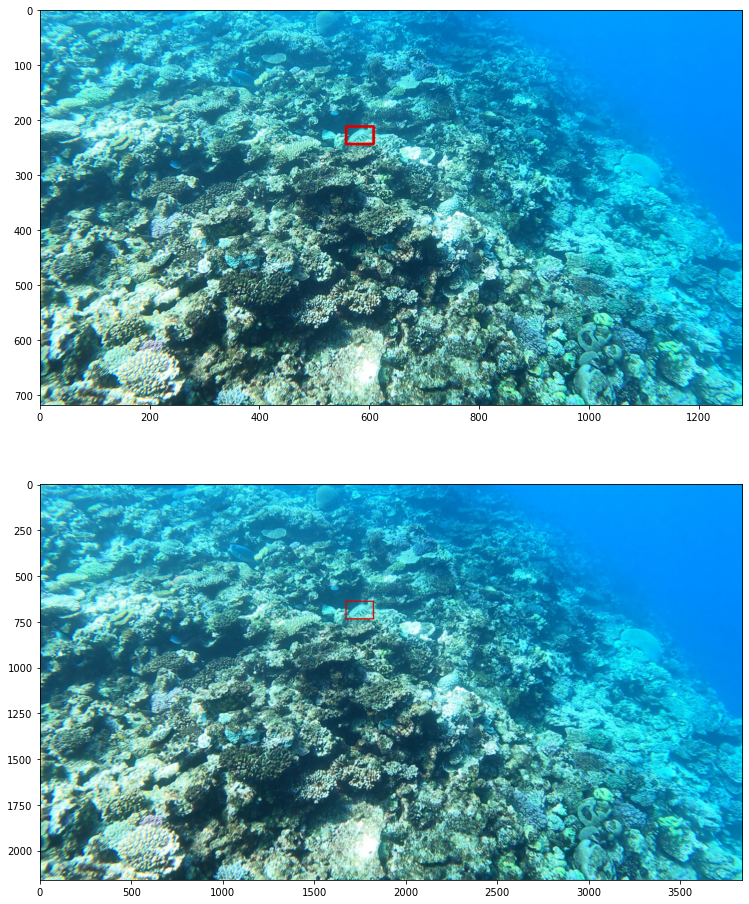

In [15]:
def factor_annot(boxes):
    for i in boxes:
        i['x'] *=3
        i['y'] *=3
        i['width'] *=3
        i['height'] *=3
        
    return boxes

new_annots = factor_annot([{'x': 557, 'y': 213, 'width': 50, 'height': 32},
                    {'x': 558, 'y': 213, 'width': 50, 'height': 32},
                    {'x': 559, 'y': 213, 'width': 50, 'height': 32}])
prev_annots = [{'x': 557, 'y': 213, 'width': 50, 'height': 32}]
train_dir = "../input/tensorflow-great-barrier-reef/train_images"

img_path_og = train_dir + "/video_0/18.jpg"
img_path_4k = "../input/data-conversion-to-4k/train_img" + "/video_0/18.jpg"
img = plt.imread(img_path_og)
img_old = cv2.rectangle(img,(prev_annots[0]["x"],prev_annots[0]["y"]),
                        (prev_annots[0]["x"]+prev_annots[0]["width"],prev_annots[0]["y"]+prev_annots[0]["height"]),
                        (220,0,0),3)

img_4k = cv2.imread(img_path_4k)
img_new = cv2.rectangle(img_4k,(new_annots[0]["x"],new_annots[0]["y"]),
                        (new_annots[0]["x"]+new_annots[0]["width"],new_annots[0]["y"]+new_annots[0]["height"]),
                        (220,0,0),6)


plt.figure(figsize=(14,16))
plt.subplot(2,1,1)
plt.imshow(img_old)

plt.subplot(2,1,2)
plt.imshow(img_new)

In [16]:
new_annots

[{'x': 1671, 'y': 639, 'width': 150, 'height': 96},
 {'x': 1674, 'y': 639, 'width': 150, 'height': 96},
 {'x': 1677, 'y': 639, 'width': 150, 'height': 96}]

In [17]:
def factor_annot(boxes):
    for i in boxes:
        i['x'] *=3
        i['y'] *=3
        i['width'] *=3
        i['height'] *=3
        
    return boxes

df_vod0 = train_df_vod0.copy() 
annots = df_vod0["annotations"]
df_vod0["annotations"] = annots.apply(factor_annot)

In [18]:
df_vod0.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,img_path,no_of_bbox
0,0,40258,16,16,0-16,"[{'x': 1677, 'y': 639, 'width': 150, 'height':...",video_0/16.jpg,1
1,0,40258,17,17,0-17,"[{'x': 1674, 'y': 639, 'width': 150, 'height':...",video_0/17.jpg,1
2,0,40258,18,18,0-18,"[{'x': 1671, 'y': 639, 'width': 150, 'height':...",video_0/18.jpg,1
3,0,40258,19,19,0-19,"[{'x': 1668, 'y': 642, 'width': 150, 'height':...",video_0/19.jpg,1
4,0,40258,20,20,0-20,"[{'x': 1665, 'y': 642, 'width': 150, 'height':...",video_0/20.jpg,1


In [19]:
plt.imread("../input/data-conversion-to-4k/train_img/video_0/" + os.listdir("../input/data-conversion-to-4k/train_img/video_0/")[0]).shape

(2160, 3840, 3)

In [20]:
plt.imread("../input/tensorflow-great-barrier-reef/train_images/video_0/0.jpg").shape

(720, 1280, 3)

In [21]:
len(os.listdir("../input/data-conversion-to-4k/train_img/video_0"))

2143

In [22]:
df_train = df_vod0.iloc[0: 1929]
df_val = df_vod0.iloc[1930:2143]

ds_train = ReefDataset(df_train)
ds_val = ReefDataset(df_val)

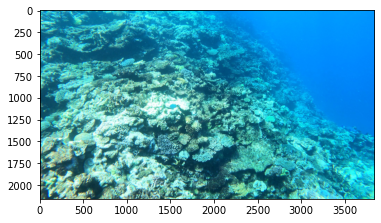

In [23]:
image, targets = ds_train[220]
# image = image.permute(2,1,0).numpy()
# plt.imshow(image)
img = image.permute(1,2,0).cpu().numpy()
# plt.imshow(image.numpy().reshape((720, 1280,3)))
plt.imshow(img)

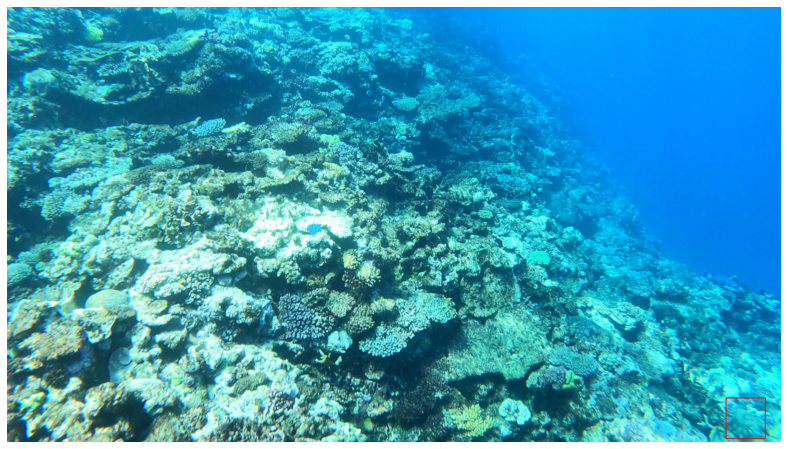

In [24]:
boxes = targets['boxes'].cpu().numpy().astype(np.int32)
img = image.permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(img,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(img);

In [25]:
def collate_fn(batch):
    return tuple(zip(*batch))

dl_train = DataLoader(ds_train, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)
dl_val = DataLoader(ds_val, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
def get_model():
    # load a model; pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    num_classes = 2  # 1 class (starfish) + background

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    model.to(DEVICE)
    return model

model = get_model()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [27]:
# images, boxes = torch.rand(2, 3, 400, 400).to(device), torch.rand(2, 11, 4).to(device)
# boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
# labels = torch.randint(0, 2, (4, 11)).to(device)
# images = list(image for image in images)
# targets = []
# for i in range(len(images)):
#     d = {}
#     d['boxes'] = boxes[i]
#     d['labels'] = labels[i]
#     targets.append(d)

In [28]:
# model(images,targets)

In [29]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0025, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

n_batches, n_batches_val = len(dl_train), len(dl_val)
validation_losses = []


for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    loss_accum = 0
    
    for batch_idx, (images, targets) in enumerate(dl_train, 1):
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        # Predict
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_accum += loss_value

        # Back-prop
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    # Validation 
    val_loss_accum = 0
        
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dl_val, 1):
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            
            val_loss_dict = model(images, targets)
            val_batch_loss = sum(loss for loss in val_loss_dict.values())
            val_loss_accum += val_batch_loss.item()
    
    # Logging
    val_loss = val_loss_accum / n_batches_val
    train_loss = loss_accum / n_batches
    validation_losses.append(val_loss)
    
    # Save model
    chk_name = f'fasterrcnn_resnet50_fpn-e{epoch}.bin'
    torch.save(model.state_dict(), chk_name)
    
    
    elapsed = time.time() - time_start
    
    print(f"[Epoch {epoch+1:2d} / {NUM_EPOCHS:2d}] Train loss: {train_loss:.3f}. Val loss: {val_loss:.3f} --> {chk_name}  [{elapsed:.0f} secs]")

[Epoch  1 /  5] Train loss: 0.193. Val loss: 0.163 --> fasterrcnn_resnet50_fpn-e0.bin  [530 secs]
[Epoch  2 /  5] Train loss: 0.162. Val loss: 0.185 --> fasterrcnn_resnet50_fpn-e1.bin  [526 secs]
[Epoch  3 /  5] Train loss: 0.148. Val loss: 0.219 --> fasterrcnn_resnet50_fpn-e2.bin  [520 secs]
[Epoch  4 /  5] Train loss: 0.131. Val loss: 0.201 --> fasterrcnn_resnet50_fpn-e3.bin  [520 secs]
[Epoch  5 /  5] Train loss: 0.122. Val loss: 0.218 --> fasterrcnn_resnet50_fpn-e4.bin  [519 secs]
